<h1 align="center">SENG 550 - Scalable Data Analytics</h1>
<h2 align="center">Final Project (NYC Taxis)</h2>
<p>By:</p>

*   Ahmed Waly
*   Ahmed Abdullah
*   Avijot Girn
*   Tanish Datta


<h1>Setup Spark</h1>

1- Install PySpark and Required Dependencies

In [ ]:
!apt-get install -qq openjdk-8-jdk-headless > /dev/null
!wget -nc -q https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
!tar -xf spark-3.3.3-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q gdown

2- Import Required Libraries

In [ ]:
import os
import findspark
import gdown

from datetime import datetime as dt
from math import radians, sin, cos, sqrt, atan2

3- Set Environment Vairables For Java Home and Spark Home

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

4- Initialize Spark Context

In [ ]:
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("NYC Taxi 550 Final Project")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

<h1>Load and Inspect Data</h1>

1- Import Training and Test DataSets

In [ ]:
data_path = "/content/data"

try:
    os.makedirs(data_path)
except OSError as e:
    print (f"Failed to create directory {data_path}. Error: {e}")
else:
    print (f"Successfully created directory {data_path}")

Failed to create directory /content/data. Error: [Errno 17] File exists: '/content/data'


In [ ]:
# Helper function to download the train and test datasets from the Google Drive Urls
def download_dataset(url, output_path):
  if not os.path.isfile(output_path):
    gdown.download(url, output_path, quiet=False)
  else:
    print(f"File {output_path} Already Exists. Skipping Download ...")

In [ ]:
train_path = f"{data_path}/train.csv"
test_path = f"{data_path}/test.csv"

train_url = 'https://drive.google.com/uc?id=1NtBfFxe0ayHPR-CY3G5JLpkvNCIkc0yq'
test_url = 'https://drive.google.com/uc?id=18EkBz4abvMRzRH01TI2gJC7lX_GqJNrb'

download_dataset(train_url, train_path)
download_dataset(test_url, test_path)

File /content/data/train.csv Already Exists. Skipping Download ...
File /content/data/test.csv Already Exists. Skipping Download ...


2- Load the Data into a DataFrame and Inspect the Data

In [ ]:
lines = (sc.textFile(train_path, 20))

df = spark.read.csv(lines, header=True, inferSchema=True)

df.show(5)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

3- Remove the Header and Load the Data into a New RDD

In [ ]:
header = lines.first()
NYC_Taxi_RDD_No_Header = lines.filter(lambda line: line != header)

print('\n'.join(NYC_Taxi_RDD_No_Header.zipWithIndex().map(lambda x: str(x[1]) + ': ' + str(x[0])).take(15)))

0: id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455
1: id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238281,40.738563537597656,-73.999481201171875,40.731151580810547,N,663
2: id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433594,40.763938903808594,-74.005332946777344,40.710086822509766,N,2124
3: id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125,-74.01226806640625,40.706718444824219,N,429
4: id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927734,-73.972923278808594,40.782520294189453,N,435
5: id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982856750488281,40.742195129394531,-73.992080688476562,40.749183654785156,N,443
6: id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017028808594,40.757839202880859,-73.957405090332031,40.765895843505859,N,341
7: id1324603,2,2

4- Filter out rows with empty or Null data points

In [ ]:
NYC_Taxi_RDD = NYC_Taxi_RDD_No_Header.filter(lambda line: all(x is not None and x.strip() != "" for x in line.split(',')))

print('\n'.join(NYC_Taxi_RDD.zipWithIndex().map(lambda x: str(x[1]) + ': ' + str(x[0])).take(15)))

0: id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455
1: id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238281,40.738563537597656,-73.999481201171875,40.731151580810547,N,663
2: id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433594,40.763938903808594,-74.005332946777344,40.710086822509766,N,2124
3: id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125,-74.01226806640625,40.706718444824219,N,429
4: id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927734,-73.972923278808594,40.782520294189453,N,435
5: id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982856750488281,40.742195129394531,-73.992080688476562,40.749183654785156,N,443
6: id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017028808594,40.757839202880859,-73.957405090332031,40.765895843505859,N,341
7: id1324603,2,2

<h1>Extract & Transform Data</h1>

1- Extract Relevant Fields From the Data and Convert Each Row to a Tuple. The Tuple Will Have the Following Fields:<br/><br/>


**Vendor Id, Pickup DateTime, Pickup Longitude, Pickup Latitude, Dropoff Longitude, Dropoff Latitude, and Trip Duration**<br/><br/>

In [ ]:
def extract_fields(NYC_Taxi_RDD):
    """Creates a record consisting of day of vendor id, pickup date and time, pickup longitude, pickup latitude, dropoff longitude, dropoff latitude, and trip duration.

    Args:
        NYC_Taxi_RDDRecord : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: a comma separated record (day of pickup, time of pickup, pickup longitude, pickup latitude, dropoff longitude, dropoff latitude, and trip duration)
    """
    fieldsList = NYC_Taxi_RDD.split(',')

    return (fieldsList[1],fieldsList[2],fieldsList[5],fieldsList[6],fieldsList[7], fieldsList[8],fieldsList[10])

In [ ]:
print(extract_fields(NYC_Taxi_RDD.take(1)[0])) # Test extract_fields on the first record of the data

('2', '2016-03-14 17:24:55', '-73.982154846191406', '40.767936706542969', '-73.964630126953125', '40.765602111816406', '455')


In [ ]:
NYC_Taxi_RDD_extracted = NYC_Taxi_RDD.map(extract_fields)

print('\n'.join(map(str, NYC_Taxi_RDD_extracted.take(5))))

('2', '2016-03-14 17:24:55', '-73.982154846191406', '40.767936706542969', '-73.964630126953125', '40.765602111816406', '455')
('1', '2016-06-12 00:43:35', '-73.980415344238281', '40.738563537597656', '-73.999481201171875', '40.731151580810547', '663')
('2', '2016-01-19 11:35:24', '-73.979026794433594', '40.763938903808594', '-74.005332946777344', '40.710086822509766', '2124')
('2', '2016-04-06 19:32:31', '-74.010040283203125', '40.719970703125', '-74.01226806640625', '40.706718444824219', '429')
('2', '2016-03-26 13:30:55', '-73.973052978515625', '40.793209075927734', '-73.972923278808594', '40.782520294189453', '435')


2- Transform Data

We will now use the pickup logitudes and latitudes to calculate the trip distance. The new tuple will have data in the following format<br/><br/>


**Vendor id, Day of Pickup, Time of Pickup, Pickup Longitude, Pickup Latitude, Dropoff Longitude, Dropoff Latitude, Trip Distance, Trip Duration**<br/><br/>

In [ ]:
def transformFields(NYC_Taxi_RDD_extracted):
    """Creates a record consisting of Vendor id, Day of Pickup, Time of Pickup, Pickup Longitude, Pickup Latitude, Dropoff Longitude, Dropoff Latitude, Trip Distance, Trip Duration.

    Args:
        NYC_Taxi_RDDRecord : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: a comma separated record (Vendor id, Day of Pickup, Time of Pickup, Pickup Longitude, Pickup Latitude, Dropoff Longitude, Dropoff Latitude, Trip Distance, Trip Duration)
    """
    date_time_obj = dt.strptime(NYC_Taxi_RDD_extracted[1], '%Y-%m-%d %H:%M:%S')
    time_extracted = str(date_time_obj.time().strftime('%H:%M:%S'))
    date_extracted = str(date_time_obj.date())

    pickup_long = radians(float(NYC_Taxi_RDD_extracted[2]))
    pickup_lat = radians(float(NYC_Taxi_RDD_extracted[3]))
    dropoff_long = radians(float(NYC_Taxi_RDD_extracted[4]))
    dropoff_lat = radians(float(NYC_Taxi_RDD_extracted[5]))

    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_long - pickup_long

    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    R = 6371.0
    distance = R * c

    return (float(NYC_Taxi_RDD_extracted[0]),date_extracted,time_extracted, float(NYC_Taxi_RDD_extracted[2]), float(NYC_Taxi_RDD_extracted[3]), float(NYC_Taxi_RDD_extracted[4]), float(NYC_Taxi_RDD_extracted[5]), distance, float(NYC_Taxi_RDD_extracted[6]))

In [ ]:
NYC_Taxi_RDD_transformed = NYC_Taxi_RDD_extracted.map(transformFields)


print('\n'.join(map(str, (NYC_Taxi_RDD_transformed.take(5)))))

(2.0, '2016-03-14', '17:24:55', -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 1.4985207796469109, 455.0)
(1.0, '2016-06-12', '00:43:35', -73.98041534423828, 40.738563537597656, -73.99948120117188, 40.73115158081055, 1.8055071687958897, 663.0)
(2.0, '2016-01-19', '11:35:24', -73.9790267944336, 40.763938903808594, -74.00533294677734, 40.710086822509766, 6.385098495252495, 2124.0)
(2.0, '2016-04-06', '19:32:31', -74.01004028320312, 40.719970703125, -74.01226806640625, 40.70671844482422, 1.4854984227709385, 429.0)
(2.0, '2016-03-26', '13:30:55', -73.97305297851562, 40.793209075927734, -73.9729232788086, 40.78252029418945, 1.1885884593338851, 435.0)


<h1>Inspect Data & Remove Outliers</h1>

1- Remove Outliers

We will use the speed of the trip to remove the outliers as it takes into account both the distance & the duration of the trip. We will consider points that are 1.5x outside the range of the middle values (IQR) as outliers (box plot method where outliers are located outside the whiskers of the plot)

In [ ]:
df = NYC_Taxi_RDD_transformed.toDF(["vendor_id", "pickup_date", "pickup_time", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "trip_distance", "trip_duration"])

for col in ["trip_distance", "trip_duration"]:
    quantiles = df.stat.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    lower_bound = quantiles[0] - 1.5 * IQR
    upper_bound = quantiles[1] + 1.5 * IQR

    df = df.filter((df[col] >= lower_bound) & (df[col] <= upper_bound))

NYC_Taxi_RDD_filtered = df.rdd

In [ ]:
df.show(5)

+---------+-----------+-----------+------------------+------------------+------------------+------------------+------------------+-------------+
|vendor_id|pickup_date|pickup_time|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|     trip_distance|trip_duration|
+---------+-----------+-----------+------------------+------------------+------------------+------------------+------------------+-------------+
|      2.0| 2016-03-14|   17:24:55| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|1.4985207796469109|        455.0|
|      1.0| 2016-06-12|   00:43:35|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|1.8055071687958897|        663.0|
|      2.0| 2016-04-06|   19:32:31|-74.01004028320312|   40.719970703125|-74.01226806640625| 40.70671844482422|1.4854984227709385|        429.0|
|      2.0| 2016-03-26|   13:30:55|-73.97305297851562|40.793209075927734| -73.9729232788086| 40.78252029418945|1.1885884593338851|

In [ ]:
df.printSchema()

root
 |-- vendor_id: double (nullable = true)
 |-- pickup_date: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_duration: double (nullable = true)



<h1>Exploratory Data Analysis</h1>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from tabulate import tabulate
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns

1- Computing Mean, Median, and standard deviation of the trip distances

In [ ]:
df_pd = df.toPandas()

mean_distance = df_pd["trip_distance"].mean()
median_distance = df_pd["trip_distance"].median()
std_dev_distance = df_pd["trip_distance"].std()

print("\nThe mean of the trip distance: {}".format(mean_distance))
print("\nThe median of the trip distance: {}".format(median_distance))
print("\nThe standard deviation of the trip distance: {}".format(std_dev_distance))



The mean of the trip distance: 2.228454900948427

The median of the trip distance: 1.817923340579748

The standard deviation of the trip distance: 1.4968164010414398


2- Computing Mean, Median, and standard deviation of the trip durations

In [ ]:
mean_duration = df_pd["trip_duration"].mean()
median_duration = df_pd["trip_duration"].median()
std_dev_duration = df_pd["trip_duration"].std()

print("\nThe mean of the trip duration: {}".format(mean_duration))
print("\nThe median of the trip duration: {}".format(median_duration))
print("\nThe standard deviation of the trip duration: {}".format(std_dev_duration))


The mean of the trip duration: 639.3974953094107

The median of the trip duration: 579.0

The standard deviation of the trip duration: 351.8636760224126


3 - Analyze the number of trip durations that are more than 10 minutes and less than 10 minutes

In [ ]:
print("\nThe number of trip_duration values more than 10 minutes: {}".format(len(df_pd[df_pd['trip_duration']>600])))


The number of trip_duration values more than 10 minutes: 596054


In [ ]:
print("\nThe number of trip_duration values less than 10 minutes: {}".format(len(df_pd[df_pd['trip_duration']<600])))


The number of trip_duration values less than 10 minutes: 651417


4- Plotting a histogram of all the trip duration frequencies

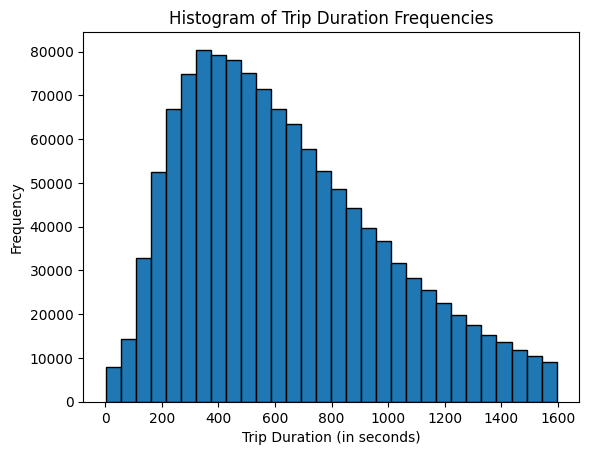

In [ ]:
plt.hist(df_pd["trip_duration"], bins=30, edgecolor="black")
plt.xlabel("Trip Duration (in seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Duration Frequencies")
plt.show()

5- Plotting a barchart for the frequencies of the different vendor IDs

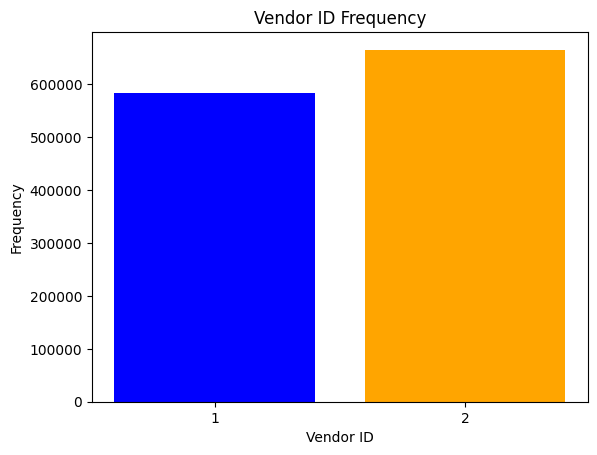

In [ ]:
colors = ['orange', 'blue']
vendor_id_counts = df_pd['vendor_id'].value_counts()
plt.bar(vendor_id_counts.index, vendor_id_counts.values, color=colors)
plt.title("Vendor ID Frequency")
plt.xlabel("Vendor ID")
plt.ylabel("Frequency")
plt.xticks(vendor_id_counts.index[:2])

plt.show()

6 - Plotting line plots of the pickup and dropoff latitude/longitude densities

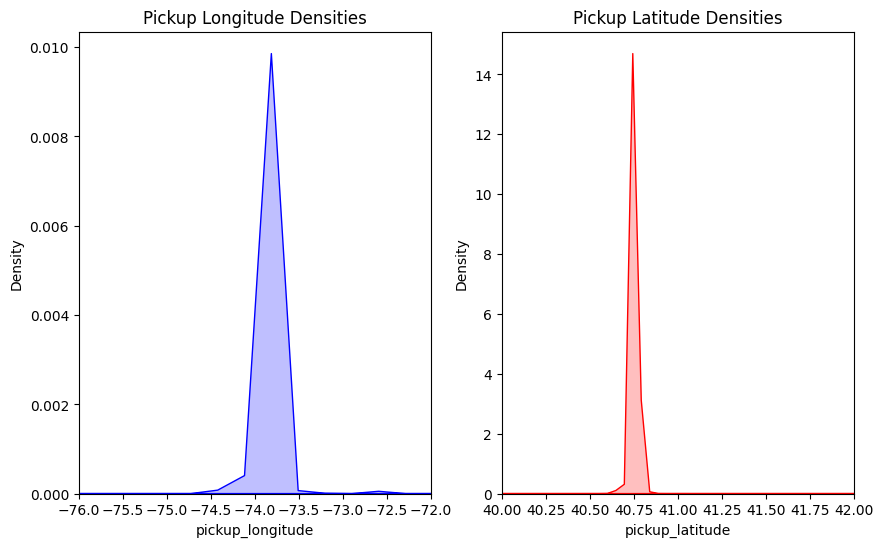

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,6))
sns.set_style('whitegrid')
sns.kdeplot(data=df_pd,x="pickup_longitude", fill=True, ax=axes[0], color='blue')
axes[0].set_title("Pickup Longitude Densities")
axes[0].set_xlim([-76,-72])

sns.kdeplot(data=df_pd,x='pickup_latitude', fill=True, ax=axes[1], color='red')
axes[1].set_title("Pickup Latitude Densities")
axes[1].set_xlim([40, 42])


fig.show()


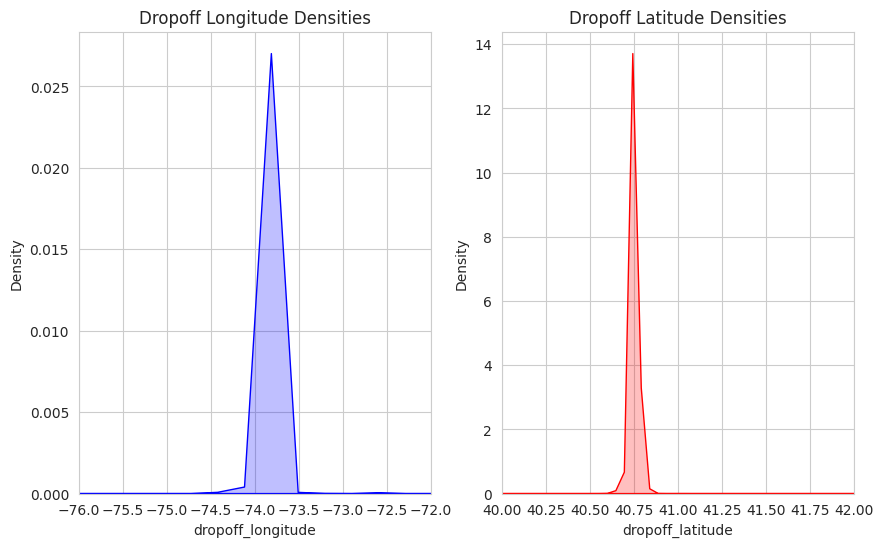

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,6))

sns.kdeplot(data=df_pd,x='dropoff_longitude', fill=True, ax=axes[0], color='blue')
axes[0].set_title("Dropoff Longitude Densities")
axes[0].set_xlim([-76,-72])

sns.kdeplot(data=df_pd,x='dropoff_latitude', fill=True, ax=axes[1], color='red')
axes[1].set_title("Dropoff Latitude Densities")
axes[1].set_xlim([40, 42])

fig.show()

7 - Plotting barcharts of the frequencies for the days of the week, the months, and the days of the month

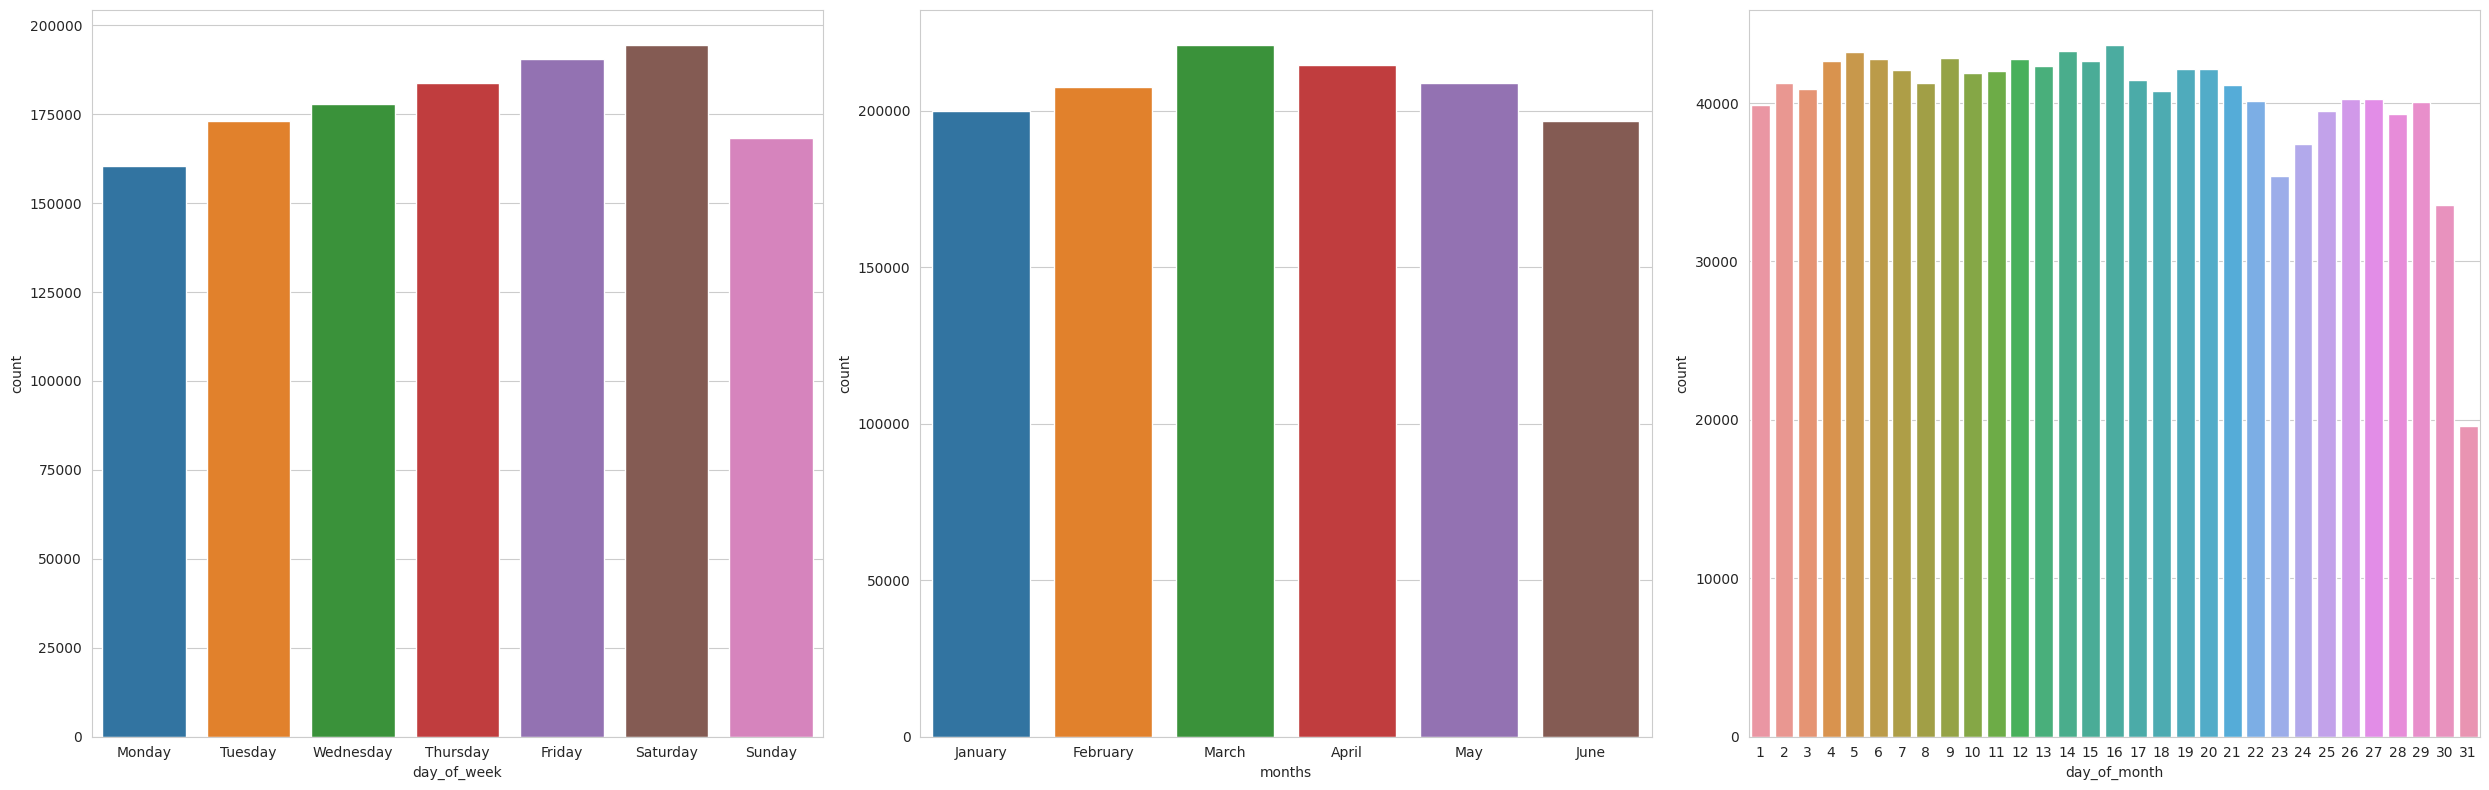

In [ ]:
df_pd['pickup_date'] = pd.to_datetime(df_pd['pickup_date'], format='%Y-%m-%d')

days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = ['January', 'February', 'March', 'April', 'May', 'June']

df_pd['day_of_week'] = pd.Categorical(df_pd['pickup_date'].dt.day_name(), categories=days_of_week_order, ordered=True)
df_pd['months'] = pd.Categorical(df_pd['pickup_date'].dt.month_name(), categories=months_order, ordered=True)
df_pd['day_of_month'] = pd.Categorical(df_pd['pickup_date'].dt.day, ordered=True)


fig, axes = plt.subplots(1, 3, figsize=(25, 8))
sns.countplot(data=df_pd, x="day_of_week", ax=axes[0])
sns.countplot(data=df_pd, x="months", ax=axes[1])
sns.countplot(data=df_pd, x="day_of_month", ax=axes[2])

fig.tight_layout()
fig.show()

8 - Plotting a scatter plot (with a slope line) of the trip durations as a function of the trip distance

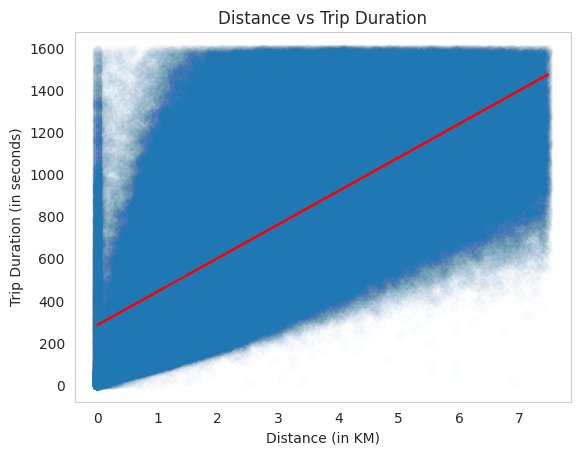

In [ ]:
distance_axis = np.array(df_pd['trip_distance'])
time_axis = np.array(df_pd['trip_duration'])

slope, intercept = np.polyfit(distance_axis, time_axis, 1)

plt.scatter(distance_axis, time_axis, alpha=0.01, marker='o')

plt.plot(distance_axis, (slope * distance_axis) + intercept, color='red', label='Regression Line')
plt.title('Distance vs Trip Duration')
plt.xlabel('Distance (in KM)')
plt.ylabel('Trip Duration (in seconds)')
plt.grid()

plt.show()

9 - Plotting a line plot of the trip durations as a function of the pickup date (grouped by vendor id)

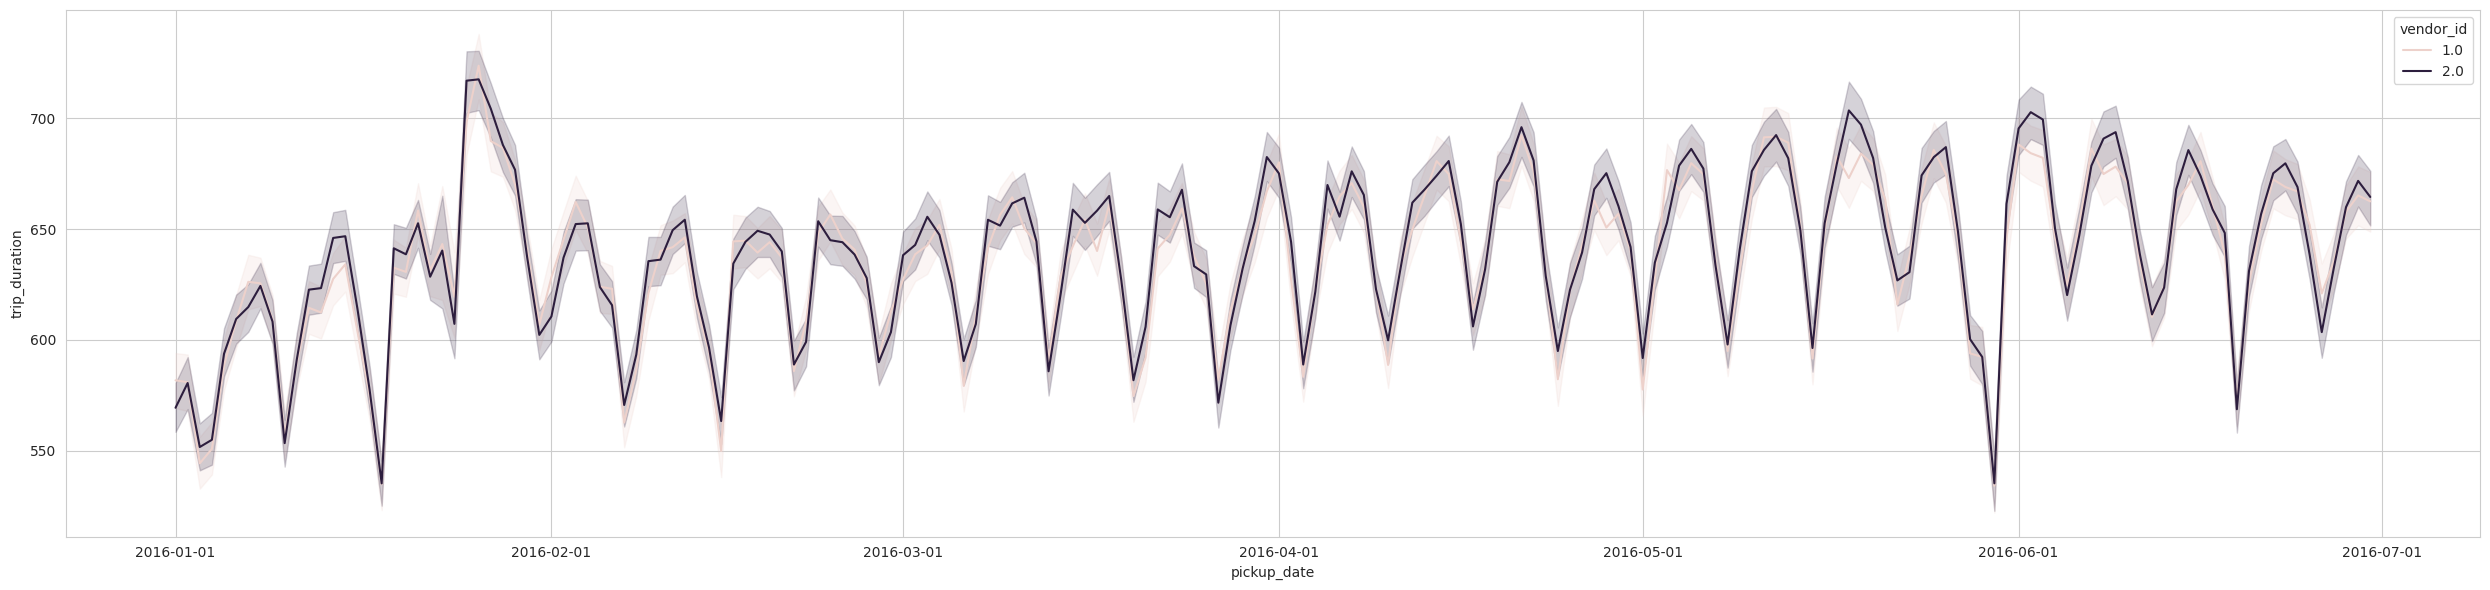

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(25, 6))
sns.lineplot(data=df_pd, x='pickup_date', y='trip_duration', hue='vendor_id')
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes.xaxis.set_major_locator(mdates.MonthLocator())
fig.tight_layout()
fig.show()

10 - Plotting a line plot of the trip durations as a function of the day of the week (grouped by vendor id)

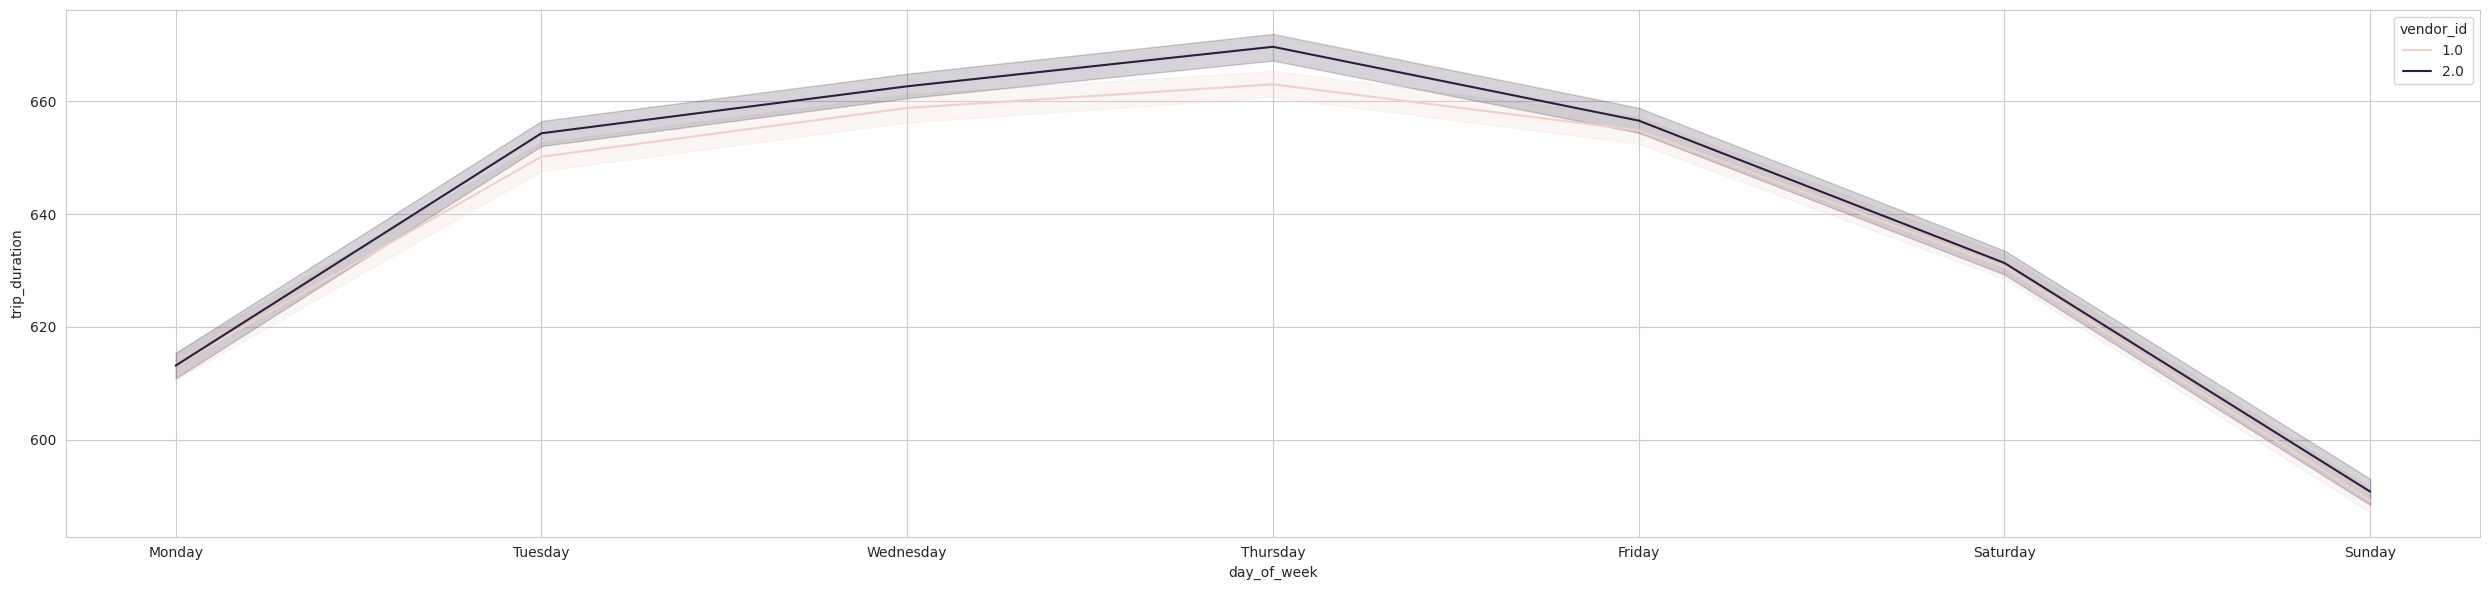

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(25, 6))
sns.lineplot(data=df_pd, x='day_of_week', y='trip_duration', hue='vendor_id')

fig.tight_layout()
fig.show()

11 - Plotting a line plot of the trip durations as a function of the month (grouped by vendor id)

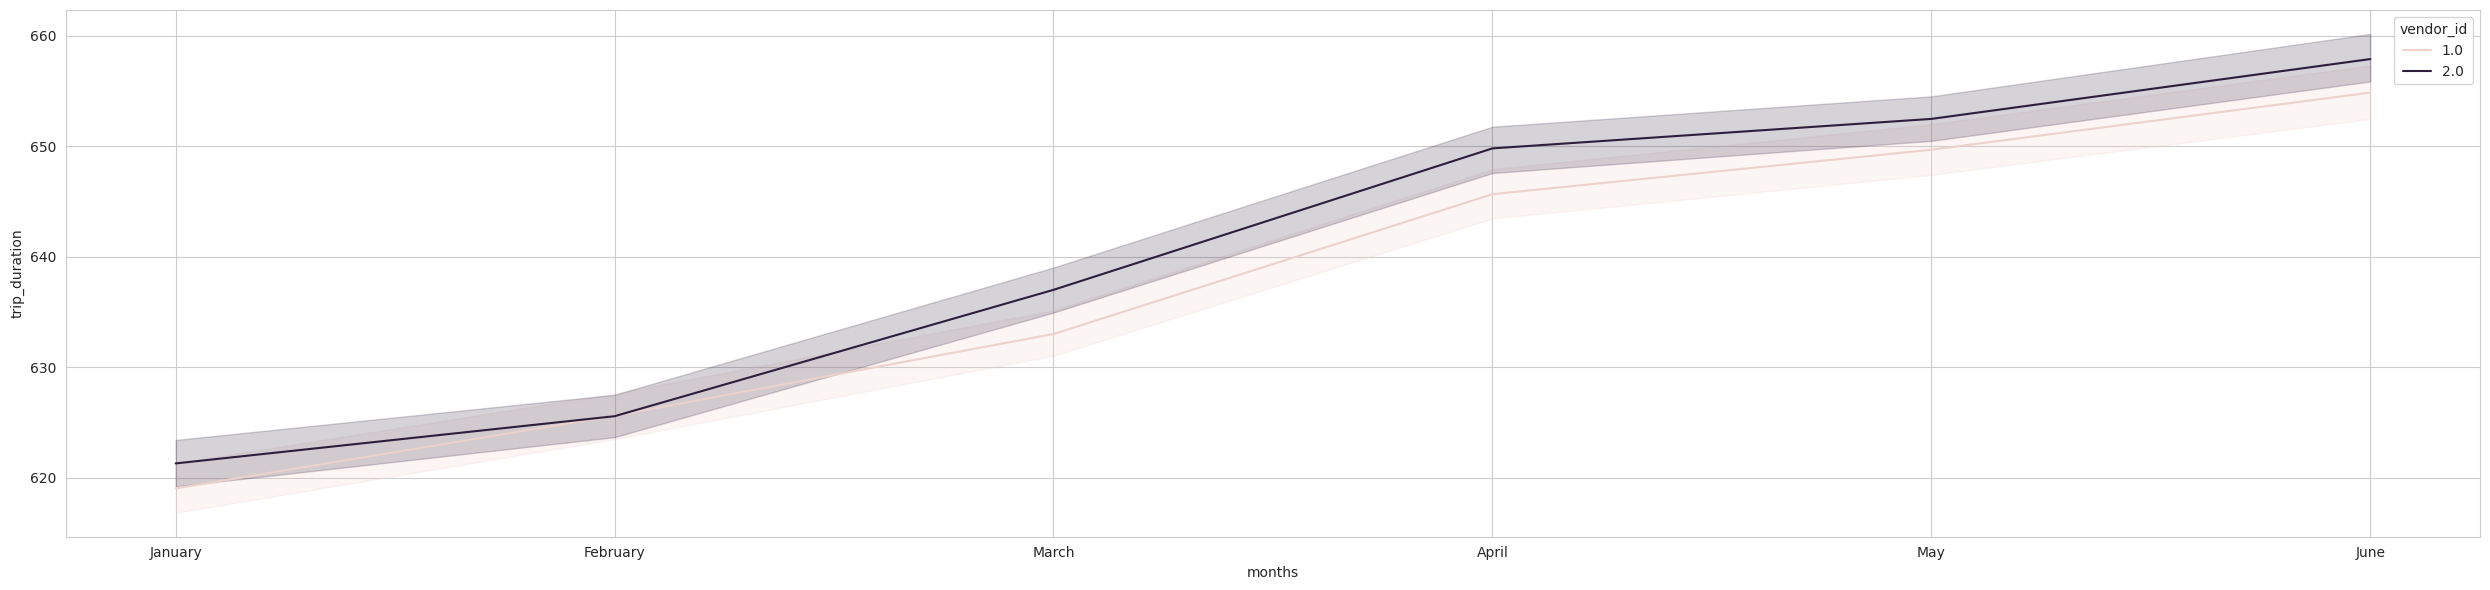

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(25, 6))
sns.lineplot(data=df_pd, x='months', y='trip_duration', hue='vendor_id')

fig.tight_layout()
fig.show()

12 - Plotting a line plot of the trip durations as a function of the day of the month (grouped by vendor id)

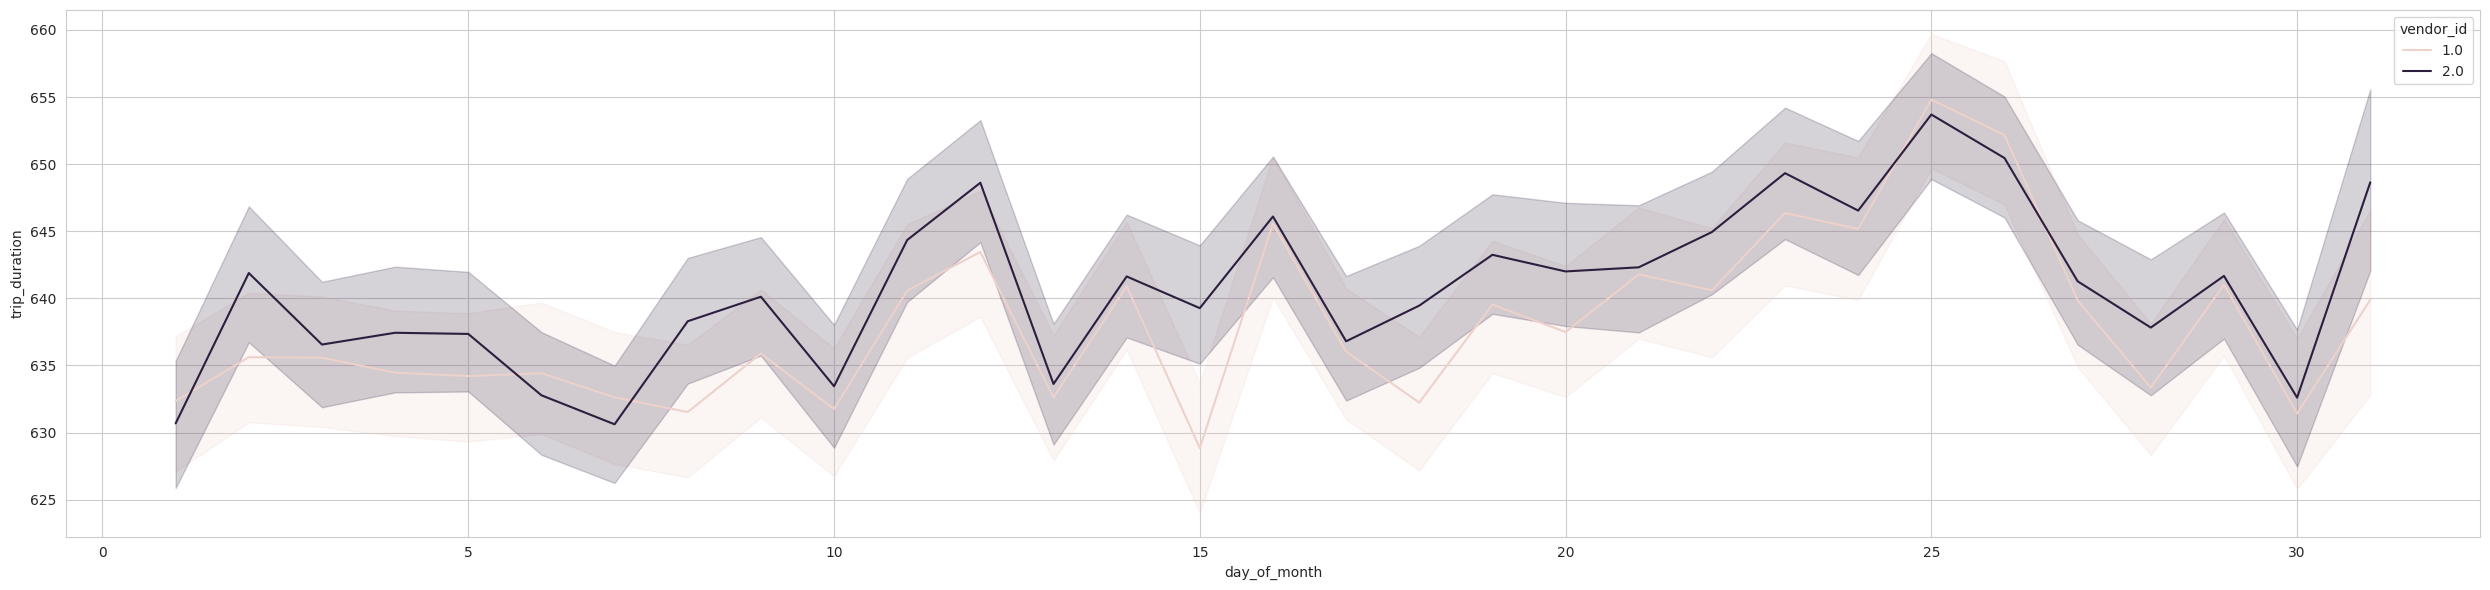

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(25, 6))
sns.lineplot(data=df_pd, x='day_of_month', y='trip_duration', hue='vendor_id')

fig.tight_layout()
fig.show()

## Feature Engineering

### Import Necessary Libraries

In [ ]:
from pyspark.sql.functions import hour, minute, second, dayofweek, month, year

### Inspect Current Data

Let's take a look at out current data after removing outliers

In [ ]:
df.show()

+---------+-----------+-----------+------------------+------------------+------------------+------------------+------------------+-------------+
|vendor_id|pickup_date|pickup_time|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|     trip_distance|trip_duration|
+---------+-----------+-----------+------------------+------------------+------------------+------------------+------------------+-------------+
|      2.0| 2016-03-14|   17:24:55| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|1.4985207796469109|        455.0|
|      1.0| 2016-06-12|   00:43:35|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|1.8055071687958897|        663.0|
|      2.0| 2016-04-06|   19:32:31|-74.01004028320312|   40.719970703125|-74.01226806640625| 40.70671844482422|1.4854984227709385|        429.0|
|      2.0| 2016-03-26|   13:30:55|-73.97305297851562|40.793209075927734| -73.9729232788086| 40.78252029418945|1.1885884593338851|

Let's take a look at out datatypes

In [ ]:
df.printSchema()

root
 |-- vendor_id: double (nullable = true)
 |-- pickup_date: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_duration: double (nullable = true)



### Extract More Feature

In this step, we will split both `date_of_pickup` and `time_of_pickup` into smaller segments that could potentially impact the `trip_duration` like `pickup_hour`, `pickup_minute`, etc.

In [ ]:
NYC_Taxi_DF_feature = df.withColumn("pickup_hour", hour("pickup_time"))\
                         .withColumn("pickup_minute", minute("pickup_time"))\
                         .withColumn("pickup_second", second("pickup_time"))\
                         .withColumn("pickup_day_of_week", dayofweek("pickup_date"))\
                         .withColumn("pickup_month", month("pickup_date"))\
                         .withColumn("pickup_year", year("pickup_date"))

## Machine Learning Models

### 1- Linear Regression Model

#### Import all necessary libraries

In [ ]:
from pyspark.sql.functions import unix_timestamp, col, split
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np

#### Extracing Labels

In [ ]:
df_features = NYC_Taxi_DF_feature.withColumn('label', NYC_Taxi_DF_feature["trip_duration"])

#### Feature Vectorization and Scaling

In this step, we will convert the input columns into vector form and scale them using StandardScaler. StandardScaler will Standardize features by removing the mean and scaling to unit variance using column summary statistics on the samples in the training set.

In [ ]:
inputCols = ['vendor_id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance',
             'pickup_hour', 'pickup_minute', 'pickup_second', 'pickup_day_of_week', 'pickup_month', 'pickup_year'] # coumns that we will use as features for the model

assembler = VectorAssembler(inputCols=inputCols, outputCol="unscaled_features")
df_features = assembler.transform(df_features)

scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)

scalerModel = scaler.fit(df_features)
scaledDF = scalerModel.transform(df_features)

#### Split Data into Training and Validation Sets

We will split our data into training and validation sets. The training set will be used for model training while the validation set will be used for model evaluation

In [ ]:
trainData, valData = scaledDF.randomSplit([0.8, 0.2], seed=42)

#### Model Training

In this step, we will initialize and fit our Linear Regression Model using the training data

In [ ]:
lrModel = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, solver="l-bfgs")
lrModel = lrModel.fit(trainData)

In [ ]:
trainingSummary = lrModel.summary

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

Coefficients: [0.5549899979228247,3.2107144130098346,15.984537269071875,-13.16359839105009,-32.8312734800357,238.8601631621994,23.365334896634774,-0.5035291332600317,0.0,17.17791708035848,12.379590302711971,0.0]
Intercept: 639.3831568952418
numIterations: 10
objectiveHistory: [0.4999994994373686, 0.43318480106470947, 0.26573935581843017, 0.2650600650381526, 0.2645805482564966, 0.2642677069201944, 0.26404767388801065, 0.264025618602078, 0.2640201833351621, 0.26401821172699724, 0.2640159601123718]


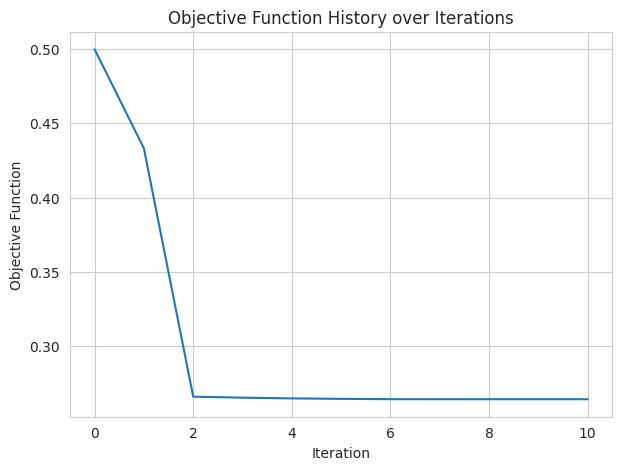

In [ ]:
objectiveHistory = trainingSummary.objectiveHistory

plt.figure(figsize=(7, 5))
plt.plot(objectiveHistory)
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('Objective Function History over Iterations')
plt.show()

#### Model Prediction

In this step, we will use the trained model to make predictions on data in the validation set

In [ ]:
train_prediction = lrModel.transform(trainData)

val_prediction = lrModel.transform(valData)

#### Model Evaluation

We will evalaute the model by computing various metrics as follows:
- RMSE - avergae magnitude of error
- R2 Score - score (0-1) to show fitness of model to predict the arrival times
- Mean Absolute Error - average of the absolute error

In [ ]:
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

##### Evaluation Metrics for Training Data

In [ ]:
rmse = evaluator.evaluate(train_prediction)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse)

r2 = evaluator.evaluate(train_prediction, {evaluator.metricName: "r2"})
print("R2 on training data = %g" % r2)

mae = evaluator.evaluate(train_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on training data = %g" % mae)

Root Mean Squared Error (RMSE) on training data = 255.417
R2 on training data = 0.473426
Mean absolute error on training data = 198.065


##### Evaluation Metrics for Validation Data

In [ ]:
rmse = evaluator.evaluate(val_prediction)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

r2 = evaluator.evaluate(val_prediction, {evaluator.metricName: "r2"})
print("R2 on validation data = %g" % r2)

mae = evaluator.evaluate(val_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on validation data = %g" % mae)

Root Mean Squared Error (RMSE) on validation data = 255.971
R2 on validation data = 0.469351
Mean absolute error on validation data = 198.206


#### Visualizing model Coefficients

In this step, we will visualize the weights of the model. This will enable us to tell which features the model put the most weight on.

+------------------+-------------------+
|           feature|        coefficient|
+------------------+-------------------+
|         vendor_id| 0.5549899979228247|
|  pickup_longitude| 3.2107144130098346|
|   pickup_latitude| 15.984537269071875|
| dropoff_longitude| -13.16359839105009|
|  dropoff_latitude|  -32.8312734800357|
|     trip_distance|  238.8601631621994|
|       pickup_hour| 23.365334896634774|
|     pickup_minute|-0.5035291332600317|
|     pickup_second|                0.0|
|pickup_day_of_week|  17.17791708035848|
|      pickup_month| 12.379590302711971|
|       pickup_year|                0.0|
+------------------+-------------------+



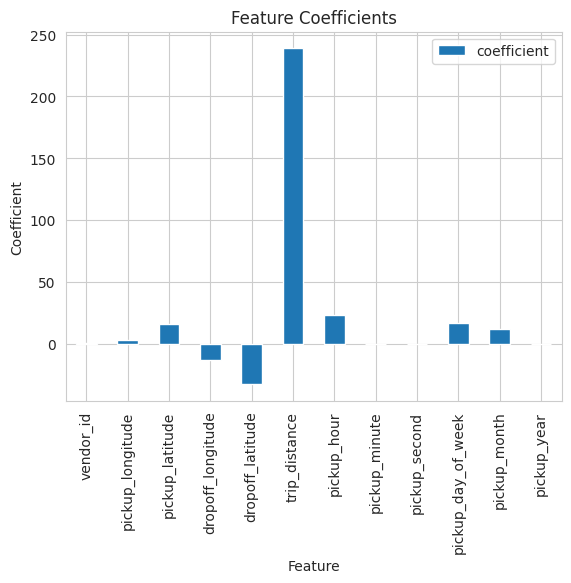

In [ ]:
features = [i for i in df_features.columns if i in inputCols]
coefficients = lrModel.coefficients.toArray().tolist()

coeff_df = spark.createDataFrame(zip(features, coefficients), schema=['feature', 'coefficient'])

coeff_df.show()

coeff_pd = coeff_df.toPandas()

coeff_pd.plot.bar(x='feature', y='coefficient')
plt.title('Feature Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

#### Error/Residuals Analysis

In this step, we will calculate the errors/residuals (actual value - predicted value) for each observation in the validation set

In [ ]:
residuals = val_prediction.select('label', 'prediction').withColumn('residual', val_prediction['label'] - val_prediction['prediction'])
residuals.show()

+------+------------------+-------------------+
| label|        prediction|           residual|
+------+------------------+-------------------+
| 823.0| 575.0180588159471| 247.98194118405286|
| 253.0| 477.1853096405878|-224.18530964058777|
| 637.0| 673.4000679783518|-36.400067978351785|
| 546.0| 643.4105109312741| -97.41051093127408|
| 234.0| 408.8657038064166| -174.8657038064166|
| 302.0|277.31707315933534| 24.682926840664663|
| 418.0| 641.1214710543661| -223.1214710543661|
|1327.0| 1222.584179438073| 104.41582056192692|
| 983.0|  896.094875691521|    86.905124308479|
| 895.0| 1105.460840470051|-210.46084047005093|
| 334.0| 535.0180252290517|-201.01802522905166|
| 556.0| 715.5175174949517|-159.51751749495168|
| 569.0|  877.703495833616|  -308.703495833616|
| 314.0| 416.5477843361237| -102.5477843361237|
| 183.0|421.34239858209776|-238.34239858209776|
| 462.0| 701.1761928634038| -239.1761928634038|
| 923.0|  1113.13135910189|-190.13135910188998|
| 855.0| 796.5314190395806| 58.468580960

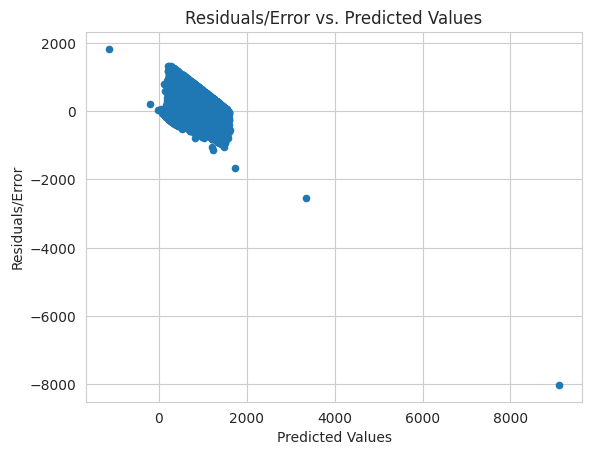

In [ ]:
residuals_pd = residuals.toPandas()
residuals_pd.plot(x='prediction', y='residual', kind='scatter')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals/Error')
plt.title('Residuals/Error vs. Predicted Values')
plt.show()

#### Hyper Parameter Optimization

We can see from the results above that our model underfits the training data, thus here we reduce the regularization parameter and increase the number of iterations to allow it to learn more complex features

In [ ]:
lrModel_new = LinearRegression(maxIter=20, regParam=0.1, elasticNetParam=0.2, tol=1e-7, solver="l-bfgs")
lrModel_new = lrModel_new.fit(trainData)

In [ ]:
trainingSummary = lrModel_new.summary

print("Coefficients: %s" % str(lrModel_new.coefficients))
print("Intercept: %s" % str(lrModel_new.intercept))

print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

Coefficients: [0.7651788987474898,16.32290846963216,14.201265585592532,-26.35294603804926,-30.83782612911279,239.56514281137927,23.517771188793795,-0.7214051279357436,0.03906522315810555,17.398514417066608,12.602197704417303,0.0]
Intercept: 639.3827427196926
numIterations: 20
objectiveHistory: [0.4999994994373686, 0.4330116305177734, 0.30444672728535377, 0.26460167868699336, 0.26413100938510253, 0.2638965657639844, 0.26360549081961315, 0.2634292595342719, 0.26341625454784623, 0.26340671538311616, 0.2634014652832932, 0.26339176603172154, 0.2633595167579518, 0.26335920901338095, 0.2633589654483064, 0.2633580616406803, 0.26335789865151765, 0.2633577687806766, 0.2633575953840659, 0.2633575843424396, 0.2633575606060104]


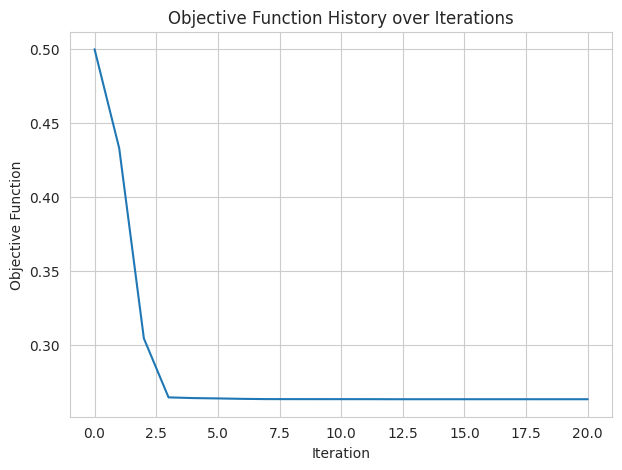

In [ ]:
objectiveHistory = trainingSummary.objectiveHistory

plt.figure(figsize=(7, 5))
plt.plot(objectiveHistory)
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('Objective Function History over Iterations')
plt.show()

### 2- Second Order model

#### Feature Transformation to 2nd Order Model

In this step, we will add second order features to our existing model. This will include the features squared and the interactions between the features (different feature values multiplied together)

In [ ]:
from pyspark.sql.functions import pow
import itertools

original_features = ['vendor_id', 'pickup_longitude', 'pickup_latitude',
             'dropoff_longitude', 'dropoff_latitude', 'trip_distance',
             'pickup_hour', 'pickup_minute', 'pickup_second',
             'pickup_day_of_week', 'pickup_month', 'pickup_year']


higher_order_features = []


for feature in original_features:
    new_col_name = feature + '_sq'
    df_features = df_features.withColumn(new_col_name, pow(col(feature), 2))
    higher_order_features.append(new_col_name)


for combination in itertools.combinations(original_features, 2):
    new_col_name = combination[0] + "_" + combination[1]
    df_features = df_features.withColumn(new_col_name, col(combination[0]) * col(combination[1]))
    higher_order_features.append(new_col_name)

In [ ]:
print(higher_order_features)

['vendor_id_sq', 'pickup_longitude_sq', 'pickup_latitude_sq', 'dropoff_longitude_sq', 'dropoff_latitude_sq', 'trip_distance_sq', 'pickup_hour_sq', 'pickup_minute_sq', 'pickup_second_sq', 'pickup_day_of_week_sq', 'pickup_month_sq', 'pickup_year_sq', 'vendor_id_pickup_longitude', 'vendor_id_pickup_latitude', 'vendor_id_dropoff_longitude', 'vendor_id_dropoff_latitude', 'vendor_id_trip_distance', 'vendor_id_pickup_hour', 'vendor_id_pickup_minute', 'vendor_id_pickup_second', 'vendor_id_pickup_day_of_week', 'vendor_id_pickup_month', 'vendor_id_pickup_year', 'pickup_longitude_pickup_latitude', 'pickup_longitude_dropoff_longitude', 'pickup_longitude_dropoff_latitude', 'pickup_longitude_trip_distance', 'pickup_longitude_pickup_hour', 'pickup_longitude_pickup_minute', 'pickup_longitude_pickup_second', 'pickup_longitude_pickup_day_of_week', 'pickup_longitude_pickup_month', 'pickup_longitude_pickup_year', 'pickup_latitude_dropoff_longitude', 'pickup_latitude_dropoff_latitude', 'pickup_latitude_tri

#### Vectorizing and Scaling Second Order Features

We will convert input columns into vector form and scale them using StandardScaler

In [ ]:
assembler = VectorAssembler(inputCols=higher_order_features, outputCol="unscaled_features_2nd_order")
df_features = assembler.transform(df_features)

scaler = StandardScaler(inputCol="unscaled_features_2nd_order", outputCol="features_2nd_order", withStd=True, withMean=True)

scalerModel = scaler.fit(df_features)
scaledDF = scalerModel.transform(df_features)

#### Split Data into Training and Validation Sets

We will split our data into training and validation sets. The training set will be used for model training while the validation set will be used for model evaluation

In [ ]:
trainData, valData = scaledDF.randomSplit([0.8, 0.2], seed=42)

#### Training Second Order Model

In this step, we will initalize and fit the linear regression model with the new training data (with second order features)

In [ ]:
lrModel = LinearRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, solver="l-bfgs").setFeaturesCol("features_2nd_order")
lrModel = lrModel.fit(trainData)

In [ ]:
trainingSummary = lrModel.summary

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

Coefficients: [-3.526726809742947,-5.401008407534941,-4.0404079589240895,-6.815890525720071,-10.82771025115637,-173.91753839509374,-217.03557988934114,-1.7016400791383213,-0.9652174962950612,-105.1983932730446,-1.5375128981924784,0.0,3.5291980578277213,-3.528415614278526,3.529744177967621,-3.5448331907456168,18.16059855442402,22.46724472957511,-2.828319933225564,-2.8474418211535295,8.30770490363791,1.149224164274704,-3.526726809742942,-1.6354676731763498,-6.1911223923419465,8.4569041357127,-62.19002724031463,-20.3418910487101,0.8408546011303945,0.9091039844558749,-6.214217289566971,1.3119447090928074,-8.78940073703975,-12.600981715073795,-4.112489960625766,62.06811996343082,20.288957577576888,-0.7712514396979769,-0.9330267983685553,6.404227305541336,-1.3345490256193968,-3.953986111019525,0.0,-62.23743702871411,-20.343224759652315,0.819128785137556,0.9152948767160625,-6.330889653194365,1.323697963260545,-6.164870084921024,61.95079710518721,20.272444660857673,-0.8329601801270835,-0.91528

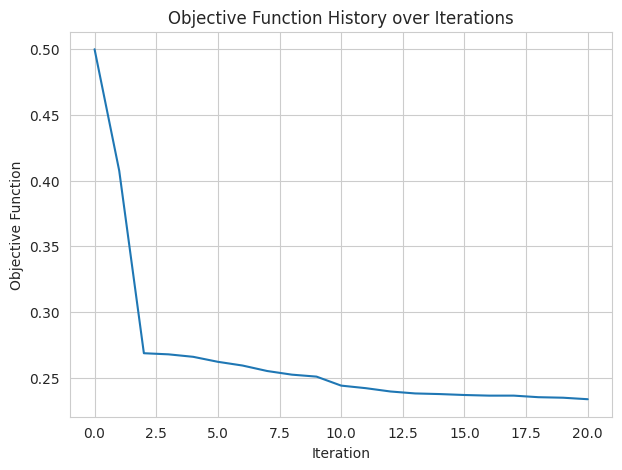

In [ ]:
objectiveHistory = trainingSummary.objectiveHistory

plt.figure(figsize=(7, 5))
plt.plot(objectiveHistory)
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('Objective Function History over Iterations')
plt.show()

#### Model Prediction

In this step, we will use the trained model to make predictions on data in the validation set

In [ ]:
train_prediction = lrModel.transform(trainData)

val_prediction = lrModel.transform(valData)

#### Model Evaluation

We will evalaute the model by computing various metrics as follows:
- RMSE - avergae magnitude of error
- R2 Score - score (0-1) to show fitness of model to predict the arrival times
- Mean Absolute Error - average of the absolute error

##### Evaluation Metrics for Training Data

In [ ]:
rmse = evaluator.evaluate(train_prediction)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse)

r2 = evaluator.evaluate(train_prediction, {evaluator.metricName: "r2"})
print("R2 on training data = %g" % r2)

mae = evaluator.evaluate(train_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on training data = %g" % mae)

Root Mean Squared Error (RMSE) on training data = 239.176
R2 on training data = 0.538263
Mean absolute error on training data = 183.515


##### Evaluation Metrics for Validation Data

In [ ]:
rmse = evaluator.evaluate(val_prediction)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

r2 = evaluator.evaluate(val_prediction, {evaluator.metricName: "r2"})
print("R2 on validation data = %g" % r2)

mae = evaluator.evaluate(val_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on validation data = %g" % mae)

Root Mean Squared Error (RMSE) on validation data = 239.459
R2 on validation data = 0.535606
Mean absolute error on validation data = 183.592


#### Error/Residuals Analysis

In this step, we will calculate the errors/residuals (actual value - predicted value) for each observation and visualize them

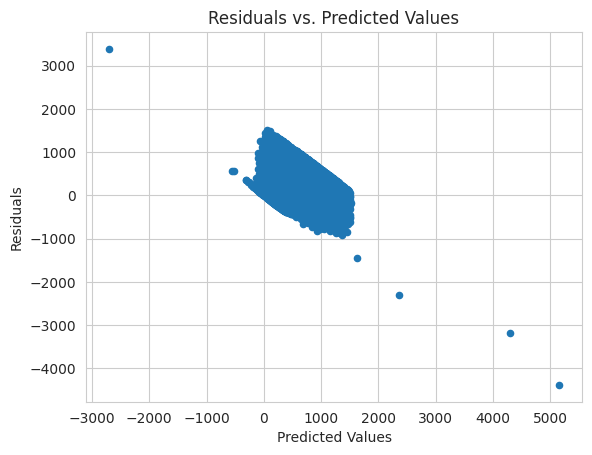

In [ ]:
residuals = val_prediction.select('label', 'prediction').withColumn('residual', val_prediction['label'] - val_prediction['prediction'])

residuals_pd = residuals.toPandas()
residuals_pd.plot(x='prediction', y='residual', kind='scatter')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

### 3- Random Forest Model

In [ ]:
from pyspark.sql.functions import unix_timestamp, col, split
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#### Feature Vectorization and Scaling

In [ ]:
inputCols = ['vendor_id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance',
             'pickup_hour', 'pickup_minute', 'pickup_second', 'pickup_day_of_week', 'pickup_month', 'pickup_year']

assembler = VectorAssembler(inputCols=inputCols, outputCol="unscaled_features__rf")
df_features = assembler.transform(df_features)

scaler = StandardScaler(inputCol="unscaled_features__rf", outputCol="features_rf", withStd=True, withMean=True)

scalerModel = scaler.fit(df_features)
scaledDF = scalerModel.transform(df_features)

#### Split Data into Training and Validation Sets

In [ ]:
trainData, valData = scaledDF.randomSplit([0.8, 0.2], seed=42)

#### Model Training

In [ ]:
rf = RandomForestRegressor(featuresCol="features_rf", numTrees=10, maxDepth=10, maxBins=32)

rfModel = rf.fit(trainData)

#### Make Predictions on Training and Validation Data

In [ ]:
train_prediction = rfModel.transform(trainData)

val_prediction = rfModel.transform(valData)

#### Model Evaluation

##### Evaluation Metrics for Training Data

In [ ]:
rmse = evaluator.evaluate(train_prediction)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse)

r2 = evaluator.evaluate(train_prediction, {evaluator.metricName: "r2"})
print("R2 on training data = %g" % r2)

mae = evaluator.evaluate(train_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on training data = %g" % mae)

Root Mean Squared Error (RMSE) on training data = 216.584
R2 on training data = 0.621374
Mean absolute error on training data = 165.144


##### Evaluation Metrics for Validation Data

In [ ]:
rmse = evaluator.evaluate(val_prediction)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

r2 = evaluator.evaluate(val_prediction, {evaluator.metricName: "r2"})
print("R2 on validation data = %g" % r2)

mae = evaluator.evaluate(val_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on validation data = %g" % mae)

Root Mean Squared Error (RMSE) on validation data = 217.855
R2 on validation data = 0.615619
Mean absolute error on validation data = 166.019


#### Feature Importance Analysis

In this step, we will inspect which features the model put the most weight on

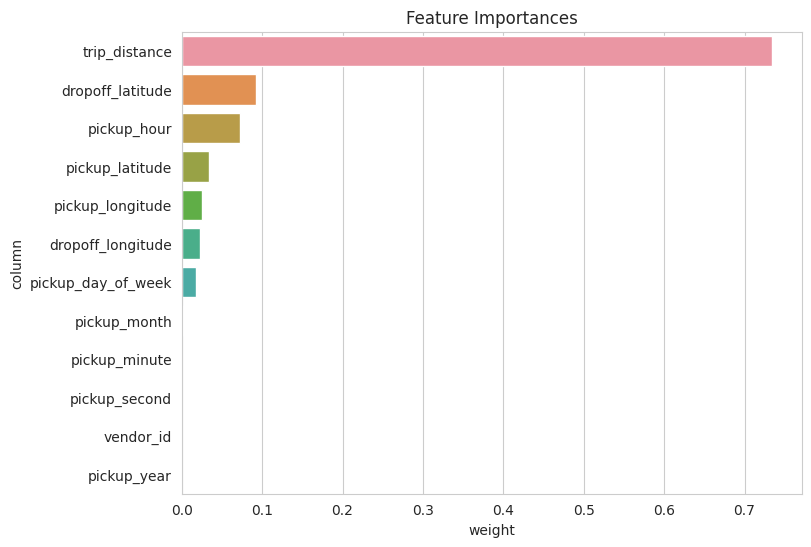

In [ ]:
featImportances = pd.DataFrame(list(zip(inputCols, rfModel.featureImportances.toArray())),
                              columns = ['column', 'weight']).sort_values('weight', ascending=False)


plt.figure(figsize=(8,6))
sns.barplot(x="weight", y="column", data=featImportances)
plt.title('Feature Importances')
plt.show()

#### Residuals Analysis

In this step, we will calculate the errors/residuals (actual value - predicted value) for each observation and visualize them

In [ ]:
residuals = val_prediction.select('label', 'prediction').withColumn('residual', val_prediction['label'] - val_prediction['prediction'])
residuals.show()

+------+------------------+-------------------+
| label|        prediction|           residual|
+------+------------------+-------------------+
| 823.0|   574.21556673105|    248.78443326895|
| 253.0|306.53409209064745| -53.53409209064745|
| 637.0| 698.8989683721435|-61.898968372143486|
| 546.0| 527.0976179114743| 18.902382088525655|
| 234.0|277.95640362423194| -43.95640362423194|
| 302.0| 206.4196916024649|   95.5803083975351|
| 418.0| 561.4500852686257|-143.45008526862568|
|1327.0| 993.7278693260457|  333.2721306739543|
| 983.0| 815.1067638462475| 167.89323615375247|
| 895.0| 794.4205807738157| 100.57941922618431|
| 334.0|  456.410633549642|  -122.410633549642|
| 556.0| 765.5246156381199|-209.52461563811994|
| 569.0|1102.6478763313048| -533.6478763313048|
| 314.0|354.84875613474907| -40.84875613474907|
| 183.0| 323.6216552141673|-140.62165521416728|
| 462.0| 951.4015782702212| -489.4015782702212|
| 923.0|1204.6712213343822|-281.67122133438215|
| 855.0| 935.4928062240011| -80.49280622

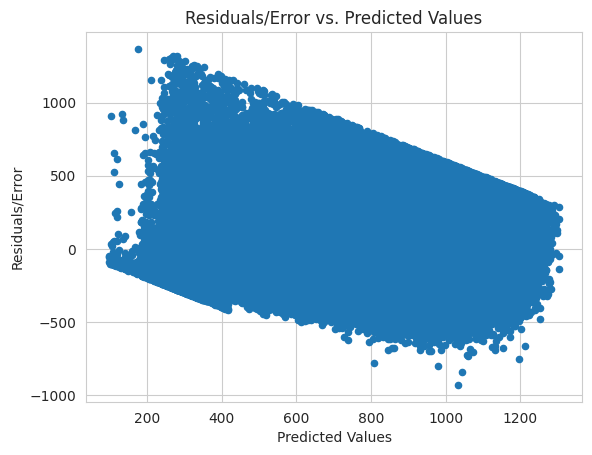

In [ ]:
residuals_pd = residuals.toPandas()
residuals_pd.plot(x='prediction', y='residual', kind='scatter')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals/Error')
plt.title('Residuals/Error vs. Predicted Values')
plt.show()

### Model Diagnostics and Optimization

We can see from the above evaluation metrics, that most models underfit the traning data. We choose to move on with the Random Forest Model as our data is non linear and wouldn't be represented well by the first two models. To solve the problem of underfitting we can do the following:
- Increase Tree Depth
- Increase maxBins

In [ ]:
rfNew = RandomForestRegressor(featuresCol="features_rf", numTrees=10, maxDepth=15, maxBins=128)

rfModelOptimized = rfNew.fit(trainData)

#### Make Predictions on Training and Validation Data

In [ ]:
train_prediction = rfModelOptimized.transform(trainData)

val_prediction = rfModelOptimized.transform(valData)

#### Model Evaluation

##### Evaluation Metrics for Training Data

In [ ]:
rmse = evaluator.evaluate(train_prediction)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse)

r2 = evaluator.evaluate(train_prediction, {evaluator.metricName: "r2"})
print("R2 on training data = %g" % r2)

mae = evaluator.evaluate(train_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on training data = %g" % mae)

Root Mean Squared Error (RMSE) on training data = 189.1
R2 on training data = 0.711371
Mean absolute error on training data = 141.781


##### Evaluation Metrics for Validation Data

In [ ]:
rmse = evaluator.evaluate(val_prediction)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

r2 = evaluator.evaluate(val_prediction, {evaluator.metricName: "r2"})
print("R2 on validation data = %g" % r2)

mae = evaluator.evaluate(val_prediction, {evaluator.metricName: "mae"})
print("Mean absolute error on validation data = %g" % mae)

Root Mean Squared Error (RMSE) on validation data = 200.926
R2 on validation data = 0.673039
Mean absolute error on validation data = 150.642


#### Residuals Analysis

In [ ]:
residuals = val_prediction.select('label', 'prediction').withColumn('residual', val_prediction['label'] - val_prediction['prediction'])
residuals.show()

+------+------------------+-------------------+
| label|        prediction|           residual|
+------+------------------+-------------------+
| 823.0| 548.1674318708993| 274.83256812910065|
| 253.0|283.72543128152415|-30.725431281524152|
| 637.0| 713.5809394369414| -76.58093943694143|
| 546.0| 527.5115987926546|  18.48840120734542|
| 234.0|305.64404882551537| -71.64404882551537|
| 302.0| 157.0624057560709|  144.9375942439291|
| 418.0| 579.3745729500096|-161.37457295000956|
|1327.0|1030.2880797224057| 296.71192027759434|
| 983.0| 770.5348843323826|  212.4651156676174|
| 895.0|  858.586960158152|  36.41303984184799|
| 334.0| 463.4737335558527|-129.47373355585268|
| 556.0| 755.6217180901392| -199.6217180901392|
| 569.0|1138.2603389553012| -569.2603389553012|
| 314.0|338.23504046855186| -24.23504046855186|
| 183.0|  314.806785119652|-131.80678511965198|
| 462.0| 1015.451461812944|  -553.451461812944|
| 923.0|1234.9487898423936| -311.9487898423936|
| 855.0|1081.2183820871978|-226.21838208

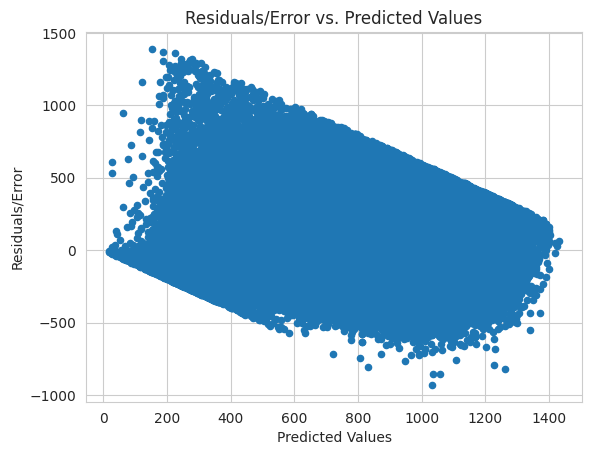

In [ ]:
residuals_pd = residuals.toPandas()
residuals_pd.plot(x='prediction', y='residual', kind='scatter')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals/Error')
plt.title('Residuals/Error vs. Predicted Values')
plt.show()

In [ ]:
!jupyter nbconvert --to html /content/Copy_of_ML_Model.ipynb

[NbConvertApp] Converting notebook /content/Copy_of_ML_Model.ipynb to html
[NbConvertApp] Writing 2591523 bytes to /content/Copy_of_ML_Model.html
